In [1]:
%matplotlib notebook
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import torch
from torch.profiler import record_function
from torch_geometric.nn.resolver import aggregation_resolver as aggr_resolver
import numpy as np


# Timing function for performance evaluation
import time
class catchtime:    
    def __init__(self, arg = 'Unnamed Context'):
#         print('__init__ called with', arg)
        self.context = arg
        
    def __enter__(self):
        self.time = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = time.perf_counter() - self.time
        self.readout = f'{self.context} took: {1000 * self.time:.3f} ms'
        print(self.readout)

# Math/parallelization library includes
import numpy as np
import torch

# Imports for neighborhood searches later on
from torch_geometric.nn import radius
from torch_scatter import scatter


# Plotting includes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.tri as tri
import random

from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

In [2]:

from scipy.interpolate import RegularGridInterpolator  
import numpy as np


def interpolant(t):
    return t*t*t*(t*(t*6 - 15) + 10)


def generate_perlin_noise_2d(
        shape, res, tileable=(False, False), interpolant=interpolant, rng = np.random.default_rng(seed=42)
):
    """Generate a 2D numpy array of perlin noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multple of res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            res.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of shape shape with the generated noise.

    Raises:
        ValueError: If shape is not a multiple of res.
    """
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]]\
             .transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*rng.random((res[0]+1, res[1]+1))
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    if tileable[0]:
        gradients[-1,:] = gradients[0,:]
    if tileable[1]:
        gradients[:,-1] = gradients[:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1)
    g00 = gradients[    :-d[0],    :-d[1]]
    g10 = gradients[d[0]:     ,    :-d[1]]
    g01 = gradients[    :-d[0],d[1]:     ]
    g11 = gradients[d[0]:     ,d[1]:     ]
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = interpolant(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)


def generate_fractal_noise_2d(
        shape, res, octaves=1, persistence=0.5,
        lacunarity=2, tileable=(False, False),
        interpolant=interpolant, seed = 1337
):
    """Generate a 2D numpy array of fractal noise.

    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multiple of lacunarity**(octaves-1)*res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            (lacunarity**(octaves-1)*res).
        octaves: The number of octaves in the noise. Defaults to 1.
        persistence: The scaling factor between two octaves.
        lacunarity: The frequency factor between two octaves.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The, interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of fractal noise and of shape shape generated by
        combining several octaves of perlin noise.

    Raises:
        ValueError: If shape is not a multiple of
            (lacunarity**(octaves-1)*res).
    """
    rng = np.random.default_rng(seed=seed)
    
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(
            shape, (frequency*res[0], frequency*res[1]), tileable, interpolant, rng
        )
        frequency *= lacunarity
        amplitude *= persistence
    return noise

def generate1DPeriodicNoise(numSamples = 1024, r = 0.75, freq = 4, octaves = 2, persistence = 0.75, lacunarity = 2, plot = False, seed = 1337):
    n = 1024
    # freq = 4
    # octaves = 2
    # persistence = 0.75
    # lacunarity = 2
    noise = generate_fractal_noise_2d([n, n], [freq,freq], octaves, persistence = persistence, lacunarity = lacunarity, seed = seed)

    interp = RegularGridInterpolator((np.linspace(-1,1,n), np.linspace(-1,1,n)), noise)


#     r = 0.75
    # numSamples = 128
    thetas = np.linspace(0, 2 * np.pi, numSamples)

    x = np.cos(thetas) * r
    y = np.sin(thetas) * r

    sampled = interp(np.vstack((x,y)).transpose())
    if plot:
        fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

        circle1 = plt.Circle((0, 0), r, color='white', ls = '--', fill = False)
        axis[0,0].imshow(noise, extent =(-1,1,-1,1))
        axis[0,0].add_patch(circle1)
        axis[0,1].plot(thetas, sampled)

        fig.tight_layout()
    return sampled


def generate1DNoise(numSamples = 1024, r = 1 / (2 * np.pi), freq = 4, octaves = 2, persistence = 0.75, lacunarity = 2, plot = False, seed = 1337):
    n = 1024
    # freq = 4
    # octaves = 2
    # persistence = 0.75
    # lacunarity = 2
    noise = generate_fractal_noise_2d([n, n], [freq, freq], octaves, persistence = persistence, lacunarity = lacunarity, seed = seed)

    interp = RegularGridInterpolator((np.linspace(-1,1,n), np.linspace(-1,1,n)), noise)


#     r = 0.75
    # numSamples = 128
    thetas = np.linspace(0, 2 * np.pi, numSamples)

    x = np.linspace(-1,1,numSamples)
    y = np.zeros(numSamples)

    sampled = interp(np.vstack((x,y)).transpose())
    if plot:
        fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

        circle1 = plt.Circle((0, 0), r, color='white', ls = '--', fill = False)
        axis[0,0].imshow(noise, extent =(-1,1,-1,1))
        axis[0,0].add_patch(circle1)
        axis[0,1].plot(thetas, sampled)

        fig.tight_layout()
    return sampled


In [3]:
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']

In [4]:


def getSpacing(n, periodic = False):
    if n == 1:
        return 2.
    else:
        return 2. / n if periodic else 2./(n-1)


centroidCache = {False:{'cuda':{},'cpu':{}},True:{'cuda':{},'cpu':{}}}
def getDistances(n, x, periodic = False):
    if n in centroidCache[periodic][x.device.type]:
        centroids = centroidCache[periodic][x.device.type][n]
        if periodic:
            spacing = getSpacing(n, True)
            offset = -1 + spacing / 2.
            ra = torch.unsqueeze(x,axis=0) - centroids
            rb = torch.unsqueeze(x,axis=0) - centroids - 2.
            rc = torch.unsqueeze(x,axis=0) - centroids + 2.
            return torch.minimum(torch.minimum(torch.abs(ra)/spacing, torch.abs(rb)/spacing), torch.abs(rc)/spacing)
        else:
            spacing = getSpacing(n, False)
            
            # centroids = torch.linspace(-1.,1.,n, device = x.device) if n > 1 else torch.constant([0.], device = x.device)
        #     tx = torch.constant(x, dtype='float32')
            r = torch.unsqueeze(x,axis=0) - centroids
            return torch.abs(r)  / spacing


    if periodic:
        spacing = getSpacing(n, True)
        offset = -1 + spacing / 2.
        
#         tx = torch.constant(x, dtype='float32')
        centroids = torch.unsqueeze(torch.linspace(-1.,1.,n+1, device = x.device)[:n],axis=1)
        centroidCache[periodic][x.device.type][n] = centroids

        ra = torch.unsqueeze(x,axis=0) - centroids
        rb = torch.unsqueeze(x,axis=0) - centroids - 2.
        rc = torch.unsqueeze(x,axis=0) - centroids + 2.
        return torch.minimum(torch.minimum(torch.abs(ra)/spacing, torch.abs(rb)/spacing), torch.abs(rc)/spacing)
        
    spacing = getSpacing(n, False)
    
    centroids = torch.linspace(-1.,1.,n, device = x.device) if n > 1 else torch.tensor([0.], device = x.device)
    centroids = torch.unsqueeze(centroids, axis = 1)
    centroidCache[periodic][x.device.type][n] = centroids
#     tx = torch.constant(x, dtype='float32')
    r = torch.unsqueeze(x,axis=0) - centroids
    return torch.abs(r)  / spacing


def evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = False):    

    k = int(epsilon)
    r = getDistances(n, x, periodic)    
    if n == 1:
        return torch.ones_like(r)
    
    cpow = lambda x, p: torch.maximum(x, torch.zeros_like(r))**p
    
    funLib = {
        'linear': lambda r:  torch.clamp(1. - r / epsilon,0,1),
        'gaussian': lambda r:  torch.exp(-(epsilon * r)**2),
        'multiquadric': lambda r: torch.sqrt(1. + (epsilon * r) **2),
        'inverse_quadric': lambda r: 1. / ( 1 + (epsilon * r) **2),
        'inverse_multiquadric': lambda r: 1. / torch.sqrt(1. + (epsilon * r) **2),
        'polyharmonic': lambda r: torch.pow(r, k) if k % 2 == 1 else torch.pow(r,k-1) * torch.log(torch.pow(r,r)),
        'bump': lambda r: torch.where(r < 1./epsilon, torch.exp(-1./(1- (epsilon * r)**2)), torch.zeros_like(r)),
        'cubic_spline': lambda r: cpow(1-r/(epsilon * 1.732051),3) - 4. * cpow(1/2-r/(epsilon * 1.732051),3),
        'quartic_spline': lambda r: cpow(1-r/(epsilon * 1.936492),4) - 5 * cpow(3/5-r/(epsilon * 1.936492),4) + 10 * cpow(1/5-r/(epsilon * 1.732051),4),
        'quintic_spline': lambda r: cpow(1-r/(epsilon * 2.121321),5) - 6 * cpow(2/3-r/(epsilon * 2.121321),5) + 15 * cpow(1/3-r/(epsilon * 2.121321),5),
        'wendland2': lambda r: cpow(1 - r/(epsilon * 1.620185), 4) * (1 + 4 * r/(epsilon * 1.620185)),
        'wendland4': lambda r: cpow(1 - r/(epsilon * 1.936492), 6) * (1 + 6 * r/(epsilon * 1.936492) + 35/3 * (r/(epsilon * 1.936492))**2),
        'wendland6': lambda r: cpow(1 - r/(epsilon * 2.207940), 8) * (1 + 8 * r/(epsilon * 2.207940) + 25 * (r/(epsilon * 2.207940)) **2 + 32 * (r * (epsilon * 2.207940))**3),
        'poly6': lambda r: cpow(1 - (r/epsilon)**2, 3),
        'spiky': lambda r: cpow(1 - r/epsilon, 3),
        'square': lambda r: torch.where(r <= epsilon, torch.ones_like(r), torch.zeros_like(r))

    }
    rbf = funLib[which]
    
#     if periodic:
#         return torch.maximum(rbf(r[0]), torch.maximum(rbf(r[1]), rbf(r[2])))
        # return torch.clip_by_value(torch.maximum(rbf(r[0]), torch.maximum(rbf(r[1]), rbf(r[2]))),0,1)   
    return rbf(r)#torch.clip_by_value(rbf(r),0,1)
    
def evalChebSeries(n,x):
    cs = []
    for i in range(n):
        if i == 0:
            cs.append(torch.ones_like(x))
        elif i == 1:
            cs.append(x)
        else:
            cs.append(2. * x * cs[i-1] - cs[i-2])
    return torch.stack(cs)
sqrt_pi_1 = 1. / np.sqrt(np.pi)

def evalChebSeries2(n,x):
    cs = []
    for i in range(n):
        if i == 0:
            cs.append(torch.ones_like(x))
        elif i == 1:
            cs.append(2 * x)
        else:
            cs.append(2. * x * cs[i-1] - cs[i-2])
    return torch.stack(cs)

def fourier(n, x):
    if n == 0:
        return torch.ones_like(x) / np.sqrt(2. * np.pi)
    elif n % 2 == 0:
        return torch.cos((n // 2 + 1) * x) * sqrt_pi_1
    return torch.sin((n // 2 + 1) * x) * sqrt_pi_1

def evalFourierSeries(n, x):
    fs = []
    for i in range(n):
        fs.append(fourier(i, x))
    return torch.stack(fs)

def evalBasisFunction(n, x, which = 'chebyshev', periodic = False):   
    s = which.split()    
#     print(s)
    if s[0] == 'chebyshev':
        return evalChebSeries(n, x)
    if s[0] == 'chebyshev2':
        return evalChebSeries2(n, x)
    if s[0] == 'fourier':
        return evalFourierSeries(n, x * np.pi)
    if s[0] == 'linear':
        return evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = periodic)        
    if s[0] == 'rbf':
        eps = 1. if len(s) < 3 else float(s[2])
        return evalRBFSeries(n, x, which = s[1], epsilon = eps, periodic = periodic)

    
def getWindowFunction(windowFunction):
    windowFn = None
    if windowFunction == 'cubicSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 - 4 * torch.clamp(1/2 - r, min = 0) ** 3
    if windowFunction == 'quarticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 - 5 * torch.clamp(3/5 - r, min = 0) ** 4 + 10 * torch.clamp(1/5- r, min = 0) ** 4
    if windowFunction == 'quinticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 - 6 * torch.clamp(2/3 - r, min = 0) ** 5 + 15 * torch.clamp(1/3 - r, min = 0) ** 5
    if windowFunction == 'Wendland2_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 * (1 + 3 * r)
    if windowFunction == 'Wendland4_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 * (1 + 5 * r + 8 * r**2)
    if windowFunction == 'Wendland6_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 7 * (1 + 7 * r + 19 * r**2 + 21 * r**3)
    if windowFunction == 'Wendland2':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 * (1 + 4 * r)
    if windowFunction == 'Wendland4':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 6 * (1 + 6 * r + 35/3 * r**2)
    if windowFunction == 'Wendland6':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 8 * (1 + 8 * r + 25 * r**2 + 32 * r**3)
    if windowFunction == 'Hoct4':
        def hoct4(x):
            alpha = 0.0927 # Subject to 0 = (1 − α)** nk−2 + A(γ − α)**nk−2 + B(β − α)**nk−2
            beta = 0.5 # Free parameter
            gamma = 0.75 # Free parameter
            nk = 4 # order of kernel

            A = (1 - beta**2) / (gamma ** (nk - 3) * (gamma ** 2 - beta ** 2))
            B = - (1 + A * gamma ** (nk - 1)) / (beta ** (nk - 1))
            P = -nk * (1 - alpha) ** (nk - 1) - nk * A * (gamma - alpha) ** (nk - 1) - nk * B * (beta - alpha) ** (nk - 1)
            Q = (1 - alpha) ** nk + A * (gamma - alpha) ** nk + B * (beta - alpha) ** nk - P * alpha

            termA = P * x + Q
            termB = (1 - x) ** nk + A * (gamma - x) ** nk + B * (beta - x) ** nk
            termC = (1 - x) ** nk + A * (gamma - x) ** nk
            termD = (1 - x) ** nk
            termE = 0 * x

            termA[x > alpha] = 0
            termB[x <= alpha] = 0
            termB[x > beta] = 0
            termC[x <= beta] = 0
            termC[x > gamma] = 0
            termD[x <= gamma] = 0
            termD[x > 1] = 0
            termE[x < 1] = 0

            return termA + termB + termC + termD + termE

        windowFn = lambda r: hoct4(r)
    if windowFunction == 'Spiky':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3
    if windowFunction == 'Mueller':
        windowFn = lambda r: torch.clamp(1 - r ** 2, min = 0) ** 3
    if windowFunction == 'poly6':
        windowFn = lambda r: torch.clamp((1 - r)**3, min = 0)
    if windowFunction == 'Parabola':
        windowFn = lambda r: torch.clamp(1 - r**2, min = 0)
    if windowFunction == 'Linear':
        windowFn = lambda r: torch.clamp(1 - r, min = 0)
    return lambda x: windowFn(x) / windowFn(torch.tensor([0]))

In [5]:
import warnings
warnings.filterwarnings("ignore")

def sampleCentered(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    means = torch.linspace(-1,1,n)
    dx = 2 / (n-1)
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, dx / dxScale, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sampleOffCentered(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    means = torch.linspace(-1,1,n)
    means = means[:-1] + torch.diff(means) / 2
    dx = 2 / (n-1)
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, dx / dxScale, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sampleUniform(n, samples, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    sampled = []
    for s in range(samples):
        s = torch.rand(n, generator = generator)
        sampled.append(s *2 - 1)
    return sampled

def sampleNormal(n, samples, dx = 0.125, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    sampled = []
    for s in range(samples):
        s = torch.normal(torch.zeros(n), torch.ones(n) * dx, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sampleCheb1(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    cpts = np.polynomial.chebyshev.chebpts1(n)
    dx = np.diff(cpts)
    dx2 = (dx[:-1] + dx[1:]) / 2
    dx = np.hstack((dx[0], dx2, dx[-1]))
    means = torch.tensor(cpts)
    var = torch.tensor(dx) / dxScale
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, var, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled
def sampleCheb2(n, samples, dxScale = 8, clamped = True, seed = None):
    generator = torch.Generator().manual_seed(seed) if seed is not None else torch.Generator().manual_seed(torch.Generator().seed())
    cpts = np.polynomial.chebyshev.chebpts2(n)
    dx = np.diff(cpts)
    dx2 = (dx[:-1] + dx[1:]) / 2
    dx = np.hstack((dx[0], dx2, dx[-1]))
    means = torch.tensor(cpts)
    var = torch.tensor(dx) / dxScale
    
    sampled = []
    for s in range(samples):
        s = torch.normal(means, var, generator = generator)
        if clamped:
            s = torch.clamp(s, -1, 1)
        sampled.append(s)
    return sampled

def sample(n, samples, method = 'centered', dxScale = 8, dx = 1/3, clamped = True, seed = None):
    if method == 'centered':
        return sampleCentered(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)
    if method == 'offCentered':
        return sampleOffCentered(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)
    if method == 'uniform':
        return sampleUniform(n, samples, seed = seed)
    if method == 'normal':
        return sampleNormal(n, samples, dx = dx, clamped = clamped, seed = seed)
    if method == 'cheb1':
        return sampleCheb1(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)
    if method == 'cheb2':
        return sampleCheb2(n, samples, dxScale = dxScale, clamped = clamped, seed = seed)

<IPython.core.display.Javascript object>


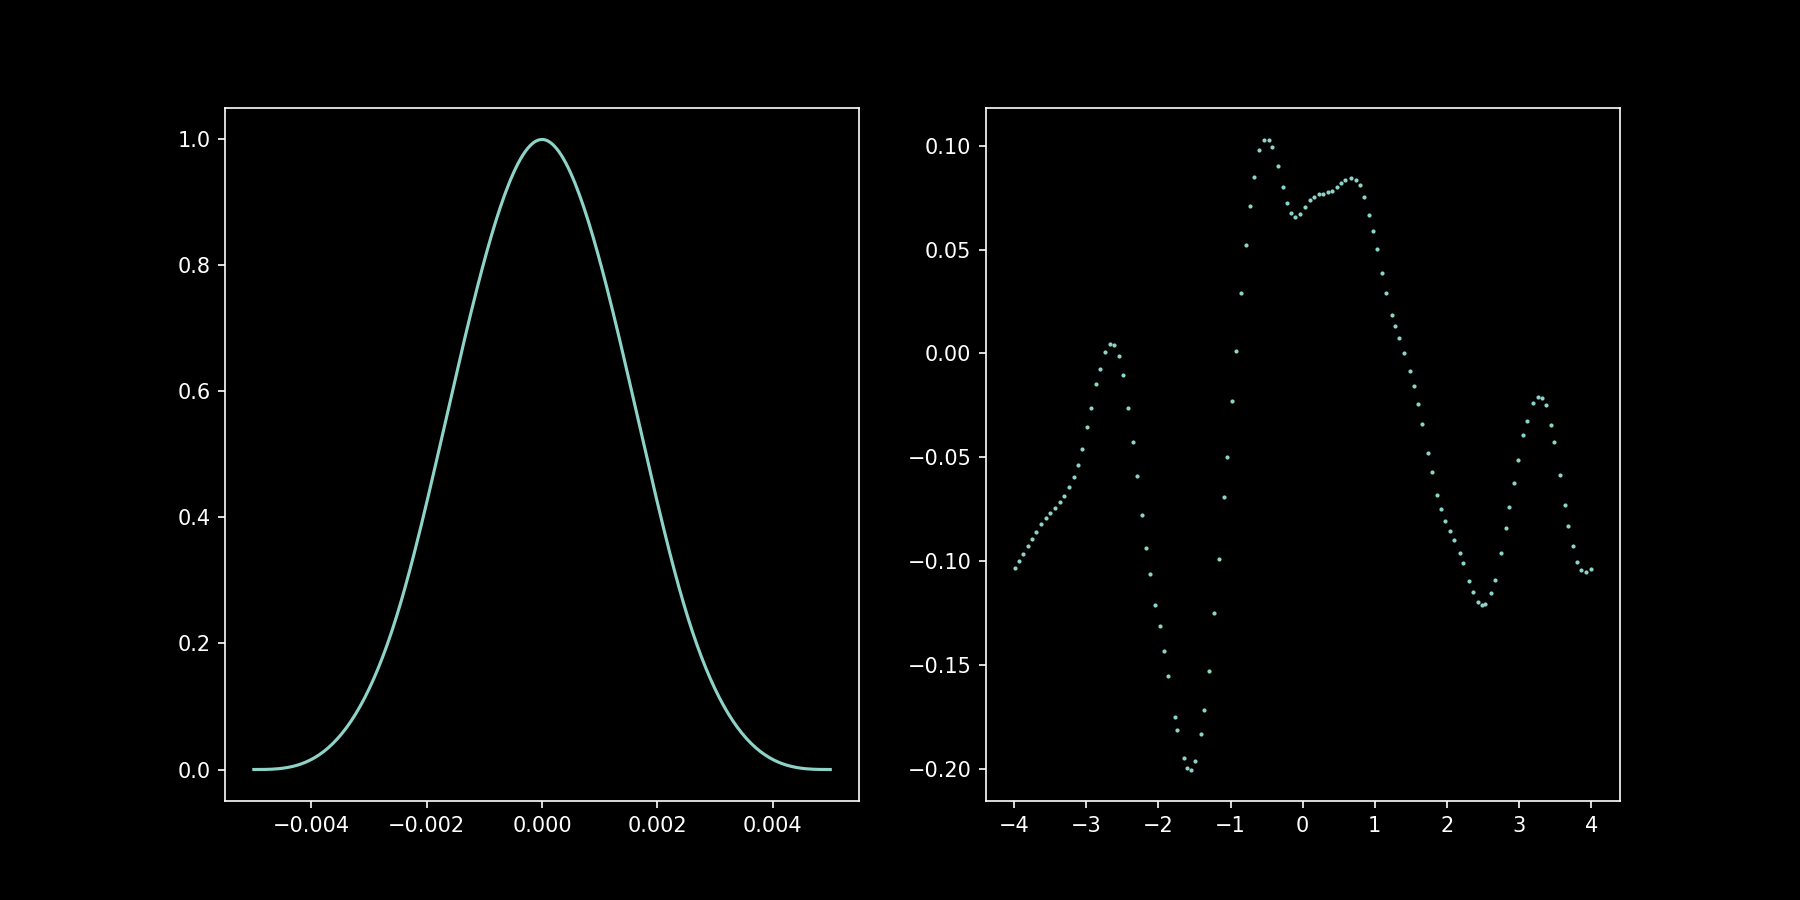

In [6]:
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)
    
support = 0.005
windowFunc = getWindowFunction('cubicSpline')
windowFn = lambda x : windowFunc(torch.abs(torch.tensor(x)) / support).numpy()
numSamples = 128
noise  = generate1DPeriodicNoise(numSamples = numSamples, r = 1 / (2 * np.pi), freq = 2, octaves = 4, plot = False, seed = 0x12345, persistence = 0.5)
noiseFn = lambda x : np.interp(x, np.linspace(-1,1,numSamples), noise) 

x = np.linspace(-1 * support,1 * support,256)
fx = windowFn(x)


axis[0,0].plot(x,fx)

sampled = sample(128, 1, method = 'centered', dxScale = 8, clamped = True, seed = None)
scale = 4

sampled = [s * scale for s in sampled]
sampledNoise = [noiseFn(s / scale) for s in sampled]
axis[0,1].scatter(sampled[0], sampledNoise[0], s = 1)

In [7]:
from typing import Dict, Optional

@torch.jit.script
def broadcast(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

@torch.jit.script
def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)


In [8]:
import scipy.integrate as integrate


Integral of windowFn: 0.3749999948870516


<IPython.core.display.Javascript object>


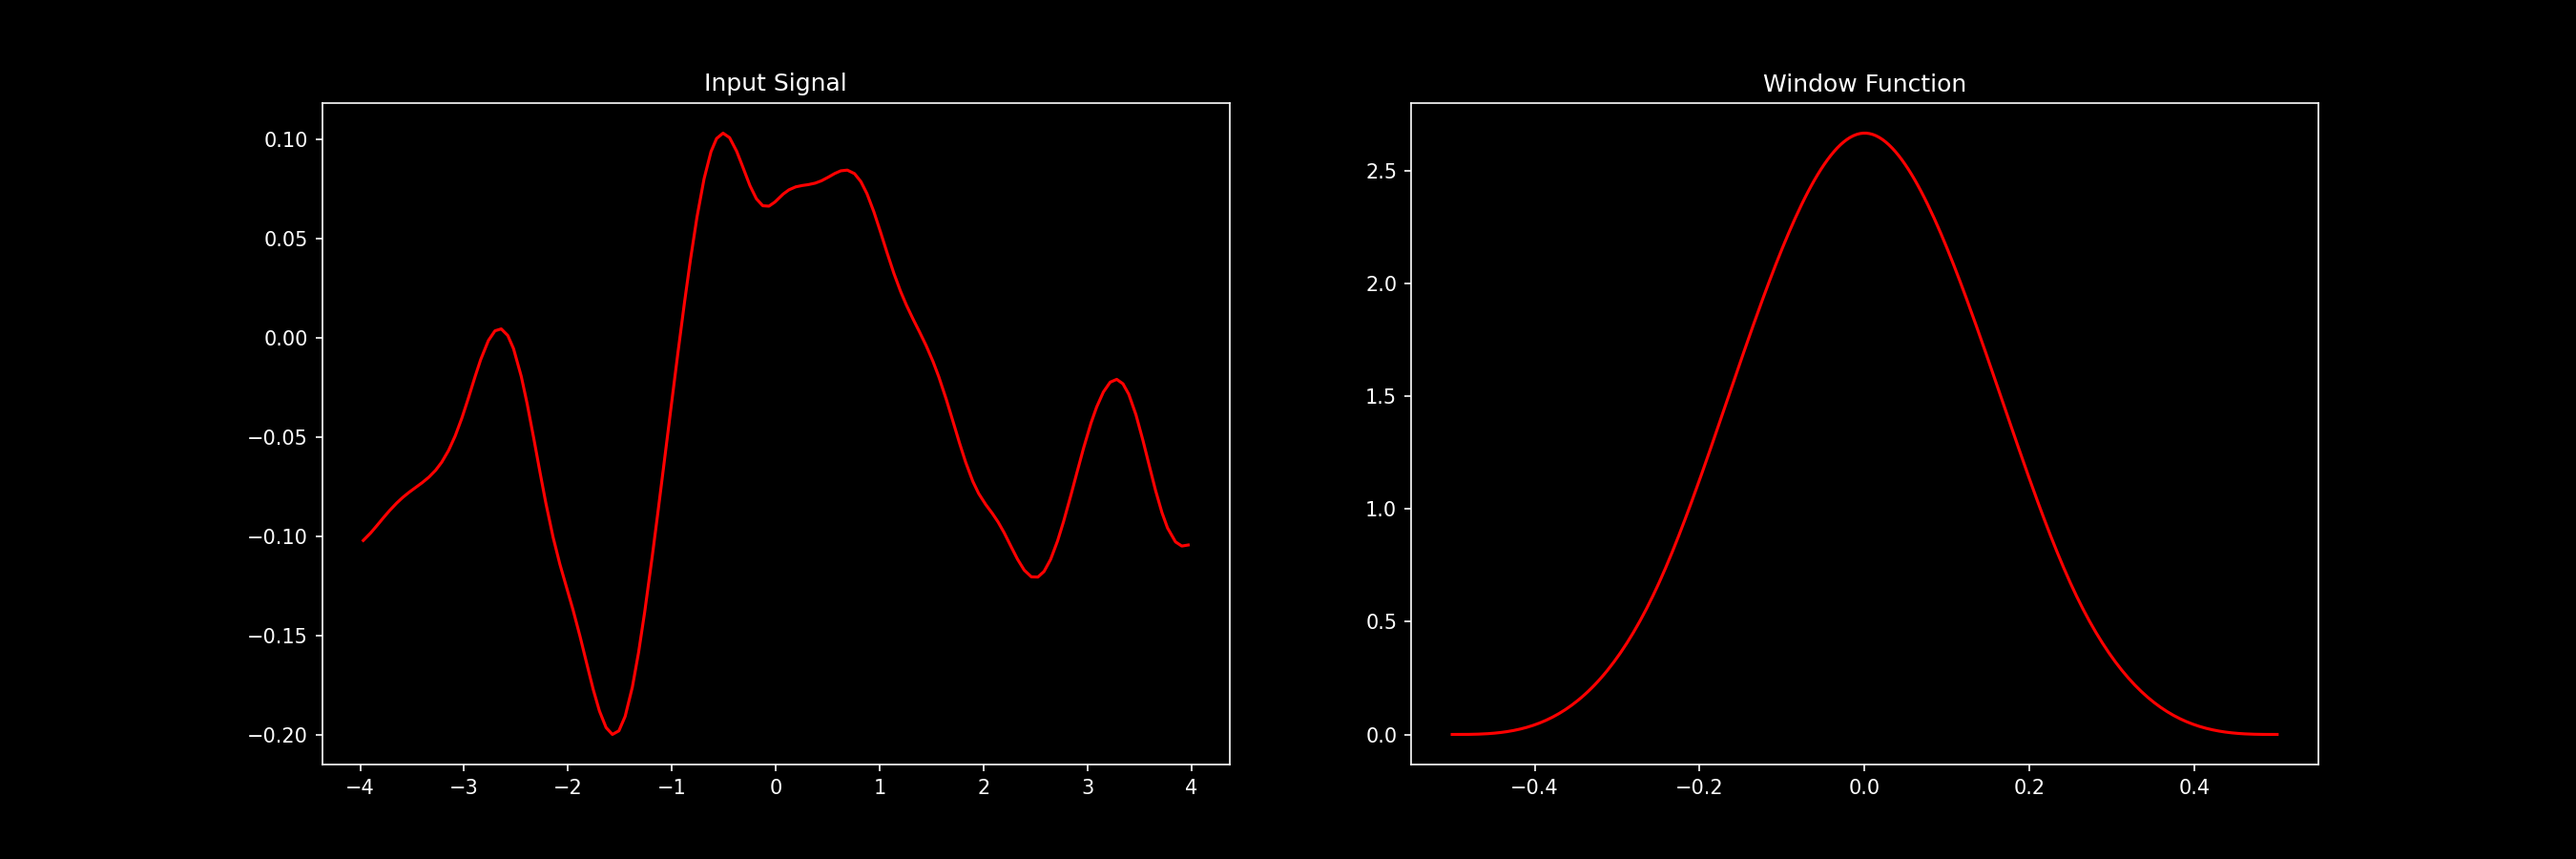

Text(0.5, 1.0, 'Window Function')

In [9]:
support = 0.5

windowFunc = getWindowFunction('cubicSpline')
winFn = lambda x : windowFunc(torch.abs(torch.tensor(x)) / support).numpy()
windowIntegral = integrate.quad(winFn, -support ,support)[0]
print('Integral of windowFn:', windowIntegral)
windowFn = lambda x: winFn(x) / windowIntegral


# windowFn = lambda x : np.sin(x / support * np.pi)
numSamples = 128
noise  = generate1DPeriodicNoise(numSamples = numSamples, r = 1 / (2 * np.pi), freq = 2, octaves = 4, plot = False, seed = 0x12345, persistence = 0.5)
noiseFn = lambda x : np.interp(x, np.linspace(-1,1,numSamples), noise) 

x = np.linspace(-1 * support,1 * support,256)
fx = windowFn(x)

sampled = sample(128, 1, method = 'offCentered', dxScale = 16, clamped = True, seed = None)

scale = 4
# sampled = [np.linspace(-1,1, 2048, endpoint=False)]

sampled = [s * scale for s in sampled]
sampledNoise = [noiseFn(s / scale) for s in sampled]

sTensor = torch.tensor(sampled[0])
fxTensor = torch.tensor(sampledNoise[0])

indices = np.arange(sTensor.shape[0])
indices = np.tile(indices, 3)
indices2 = np.arange(indices.shape[0])

positions = np.hstack((sTensor.numpy() - scale * 2, sTensor.numpy(), sTensor.numpy() + scale * 2))
dij = (positions[:,None] - positions[None,:])
neighbor_j = np.hstack([indices[np.abs(dij[:, sTensor.shape[0] + i]) <= support] for i in range(sTensor.shape[0])])
neighbor_i = np.hstack([np.ones(indices[np.abs(dij[:, sTensor.shape[0] + i]) <= support].shape[0], dtype = np.int64) * i for i in range(sTensor.shape[0])])

neighbors = torch.tensor(np.vstack((neighbor_i, neighbor_j)), dtype = torch.int64)
neighborDistances = torch.tensor(np.hstack([dij[np.abs(dij[:, sTensor.shape[0] + i]) <= support, sTensor.shape[0] + i] for i in range(sTensor.shape[0])]))

i,j = neighbors
funs = windowFn(neighborDistances)

area = scale * 2 / sTensor.shape[0]

fig, axis = plt.subplots(1, 2, figsize=(18,6), sharex = False, sharey = False, squeeze = False)

x = np.linspace(-1 * support,1 * support,256)
fx = windowFn(x)

axis[0,0].plot(sampled[0], sampledNoise[0], 'red')
axis[0,0].set_title('Input Signal')
axis[0,1].plot(x,fx, 'red')
axis[0,1].set_title('Window Function')


<IPython.core.display.Javascript object>


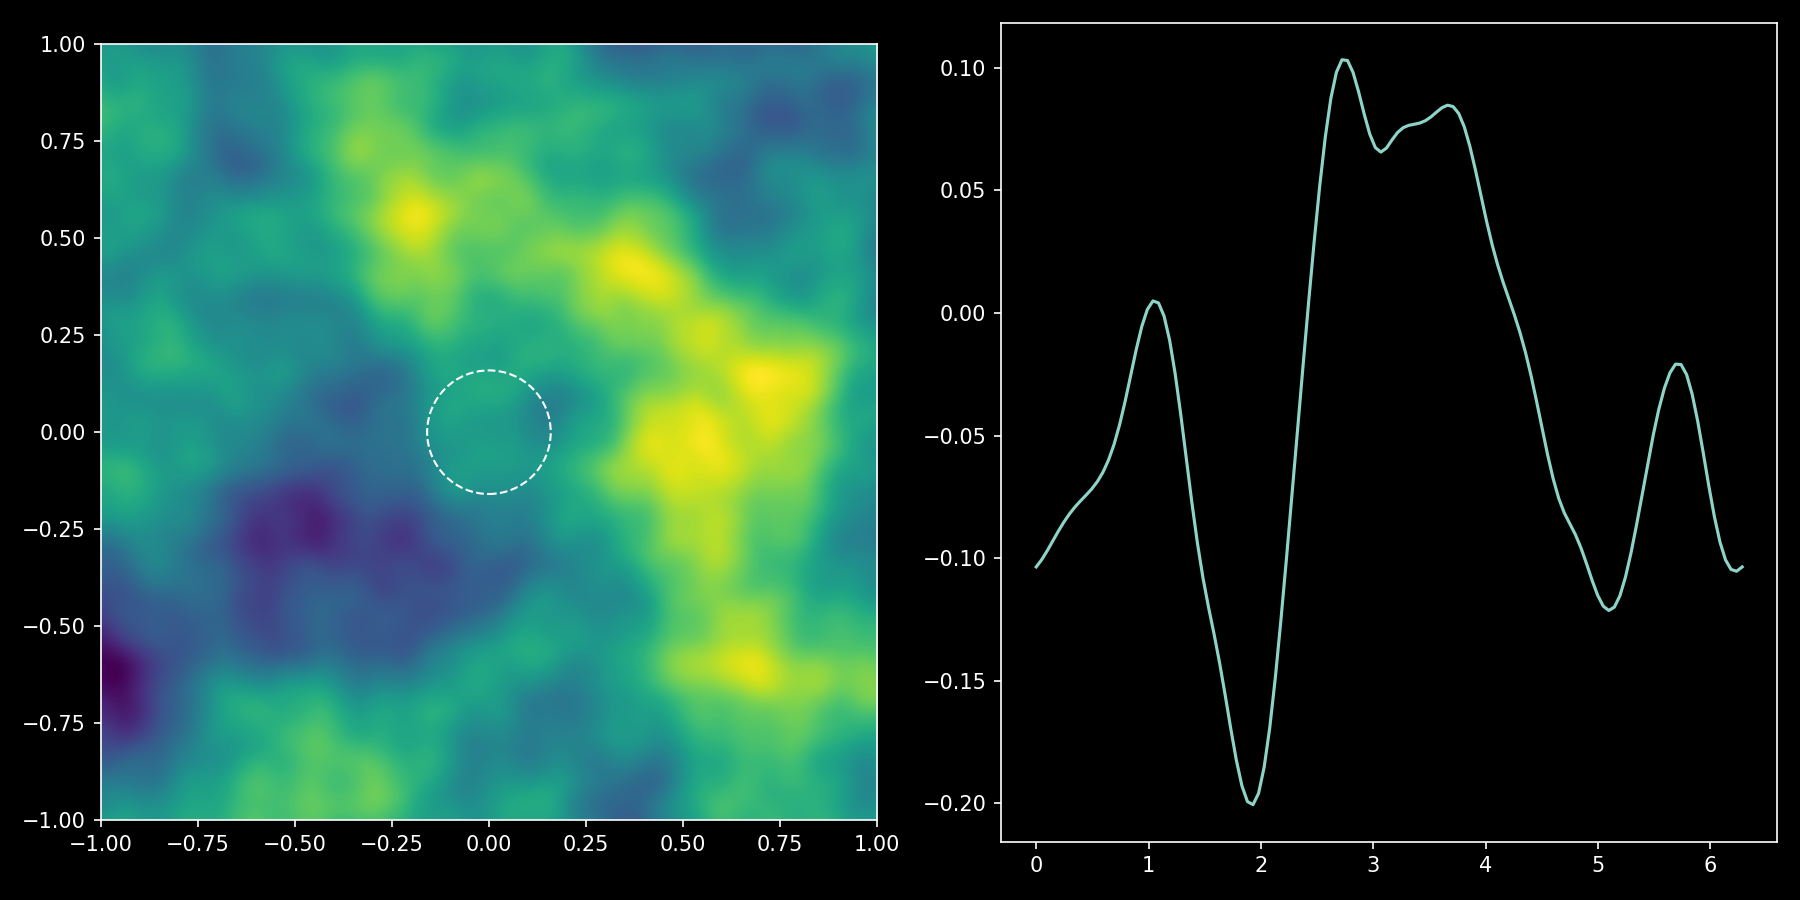

-0.2005099705210106
Integral of noiseFn: 0.08052309230876425
Integral of windowFn: 0.9999999540852521


In [10]:

noise  = generate1DPeriodicNoise(numSamples = numSamples, r = 1 / (2 * np.pi), freq = 2, octaves = 4, plot = True, seed = 0x12345, persistence = 0.5)
noiseFn = lambda x : np.interp(x, np.linspace(-support,support,numSamples), noise) 
minVal = np.min(noiseFn(np.linspace(-support,support,numSamples)))
maxVal = np.max(noiseFn(np.linspace(-support,support,numSamples)))
# minVal = 0
print(minVal)

noiseIntegral = integrate.quad(lambda x: (noiseFn(x) - minVal) * winFn(x), -support ,support)[0]
print('Integral of noiseFn:', noiseIntegral)
windowFn = lambda x : (noiseFn(x) - minVal)* winFn(x) / noiseIntegral
integral = integrate.quad(windowFn, -support ,support)[0]
print('Integral of windowFn:', integral)

# noiseIntegral = integrate.quad(lambda x: (noiseFn(x) - minVal), -support ,support)[0]
# print('Integral of noiseFn:', noiseIntegral)
# windowFn = lambda x : (noiseFn(x) - minVal) / noiseIntegral
# integral = integrate.quad(windowFn, -support ,support)[0]
# print('Integral of windowFn:', integral)

Integral of initialFn: -0.2882939030910041
Integral of finalFn: -0.29323156687590707


<IPython.core.display.Javascript object>


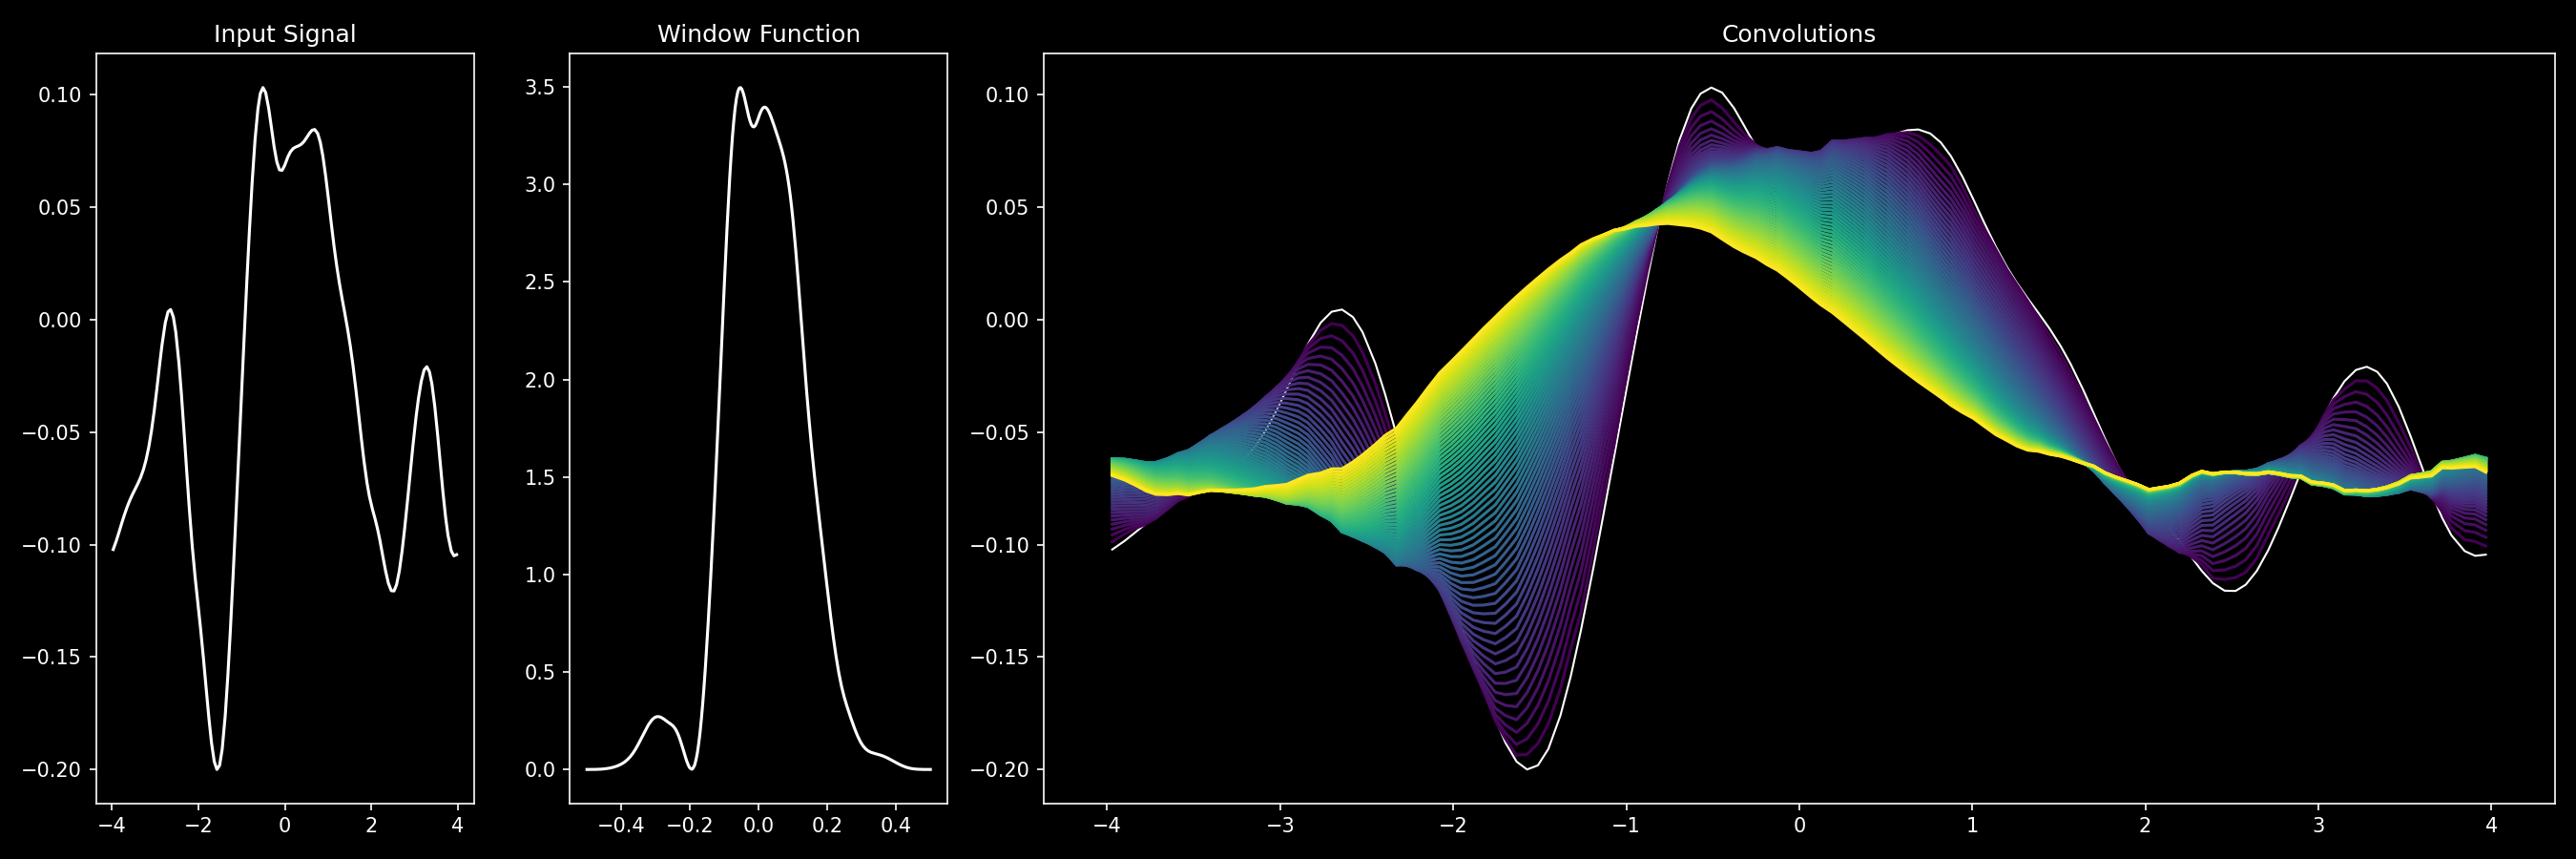

In [12]:

ans = torch.clone(fxTensor)
convs = []
iterations =  64
funs = windowFn(neighborDistances)

for it in range(iterations):
#     print(i)
#     print(ans.shape, ans)
    ansc = torch.clone(scatter_sum(ans[j] * funs * area, i))
#     print(ans.shape)
#     print('ansc', ansc)
    convs.append(ansc)
    ans = ansc
    
initialFn = lambda x: np.interp(x, np.linspace(-scale,scale, fxTensor.shape[0]), fxTensor.numpy()) 
finalFn = lambda x: np.interp(x, np.linspace(-scale,scale, fxTensor.shape[0]), convs[-1].numpy()) 

integral = integrate.quad(initialFn, -scale ,scale)[0]
print('Integral of initialFn:', integral)
integral = integrate.quad(finalFn, -scale ,scale)[0]
print('Integral of finalFn:', integral)

fig, axis = plt.subplots(1, 3, figsize=(18,6),gridspec_kw={'width_ratios': [1,1,4]}, sharex = False, sharey = False, squeeze = False)

x = np.linspace(-1 * support,1 * support,256)
fx = windowFn(x)

axis[0,0].plot(sampled[0], sampledNoise[0], 'white')
axis[0,0].set_title('Input Signal')
axis[0,1].plot(x,fx, 'white')
axis[0,1].set_title('Window Function')

axis[0,2].plot(sampled[0], sampledNoise[0], lw = 1, c = 'white')
axis[0,2].set_title('Convolutions')
for it in range(iterations):
    c = cmap(1 / (len(convs) - 1)* it)
    axis[0,2].plot(sampled[0], convs[it], c = c)
    
    fig.tight_layout()

Integral of initialFn: -0.2882939030910041
Integral of finalFn: -0.15412148158159383


<IPython.core.display.Javascript object>


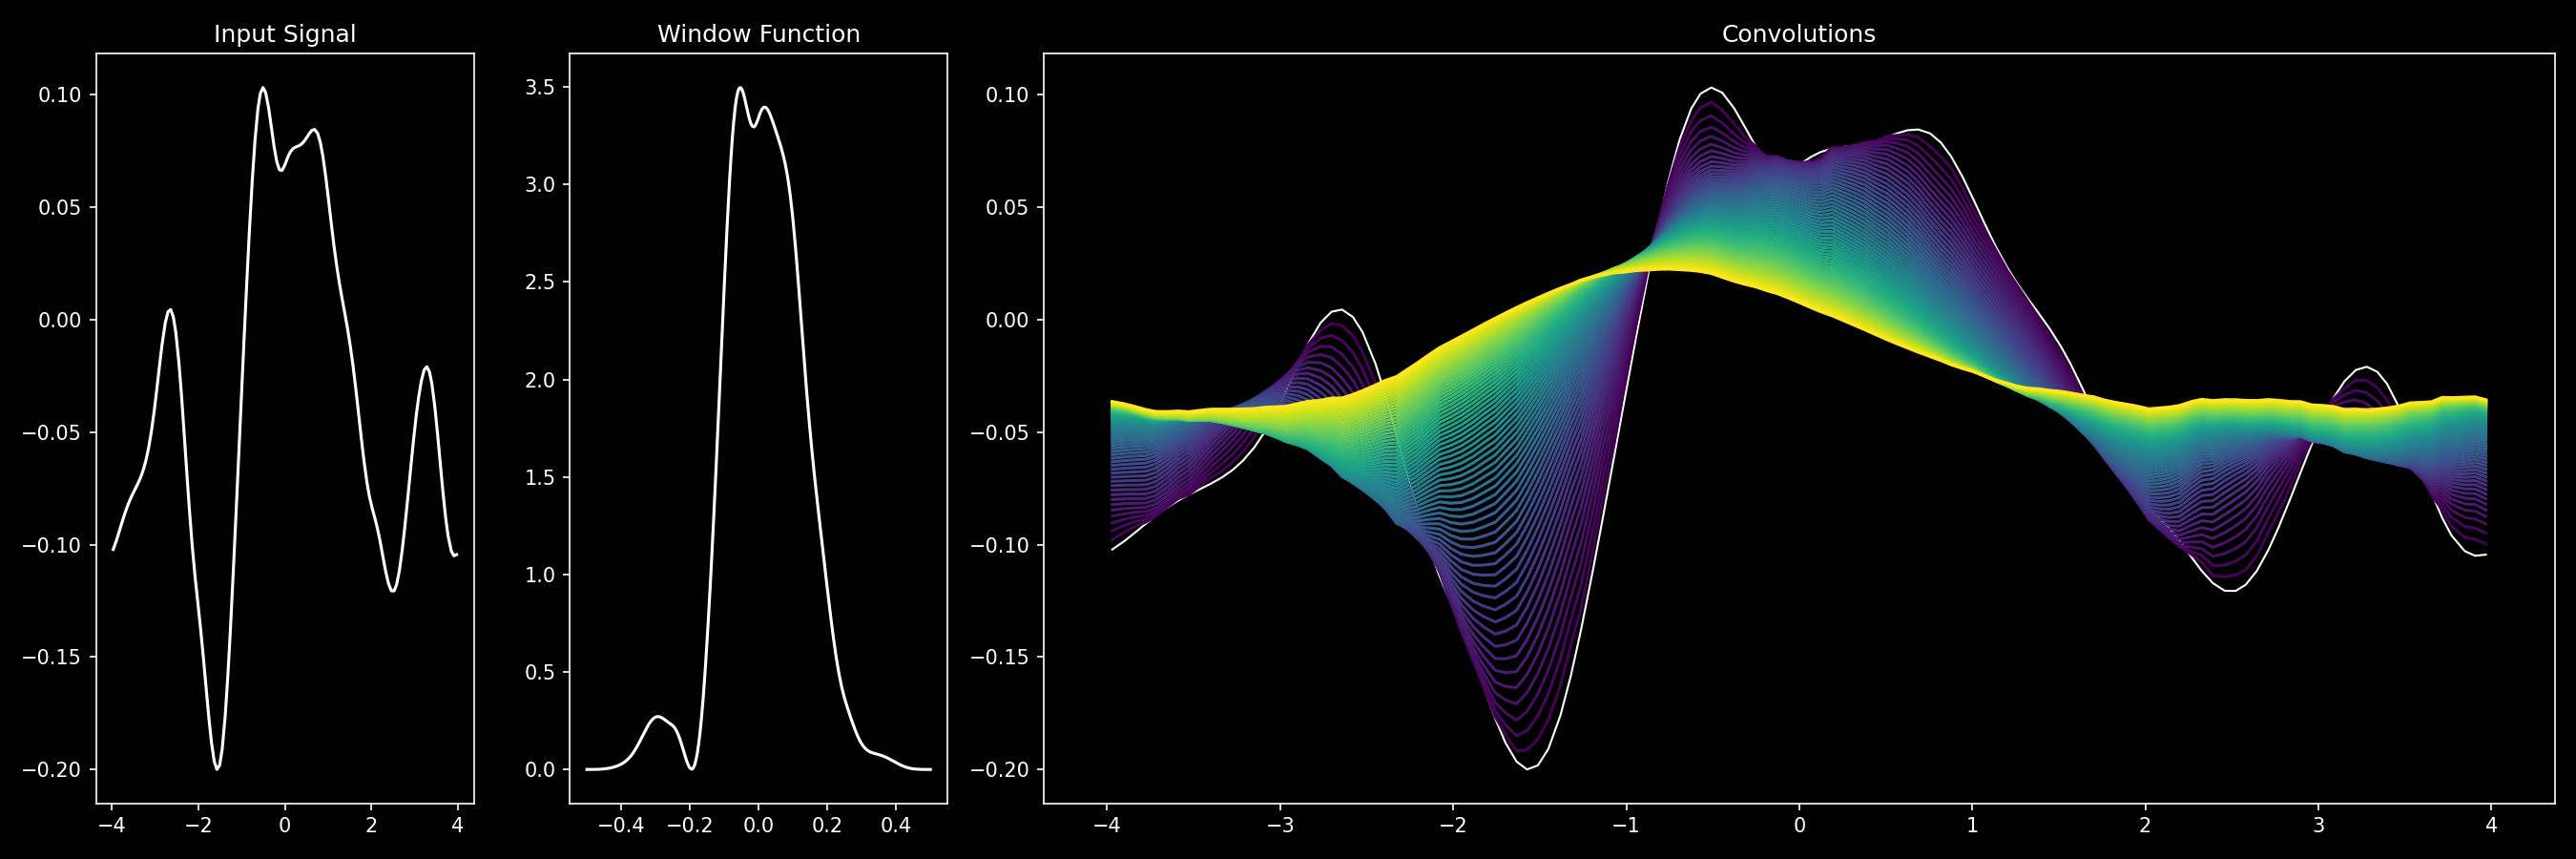

In [15]:

ans = torch.clone(fxTensor)
convs = []
iterations =  64
funs = windowFn(neighborDistances) * 0.99

for it in range(iterations):
#     print(i)
#     print(ans.shape, ans)
    ansc = torch.clone(scatter_sum(ans[j] * funs * area, i))
#     print(ans.shape)
#     print('ansc', ansc)
    convs.append(ansc)
    ans = ansc
    
initialFn = lambda x: np.interp(x, np.linspace(-scale,scale, fxTensor.shape[0]), fxTensor.numpy()) 
finalFn = lambda x: np.interp(x, np.linspace(-scale,scale, fxTensor.shape[0]), convs[-1].numpy()) 

integral = integrate.quad(initialFn, -scale ,scale)[0]
print('Integral of initialFn:', integral)
integral = integrate.quad(finalFn, -scale ,scale)[0]
print('Integral of finalFn:', integral)

fig, axis = plt.subplots(1, 3, figsize=(18,6),gridspec_kw={'width_ratios': [1,1,4]}, sharex = False, sharey = False, squeeze = False)

x = np.linspace(-1 * support,1 * support,256)
fx = windowFn(x)

axis[0,0].plot(sampled[0], sampledNoise[0], 'white')
axis[0,0].set_title('Input Signal')
axis[0,1].plot(x,fx, 'white')
axis[0,1].set_title('Window Function')

axis[0,2].plot(sampled[0], sampledNoise[0], lw = 1, c = 'white')
axis[0,2].set_title('Convolutions')
for it in range(iterations):
    c = cmap(1 / (len(convs) - 1)* it)
    axis[0,2].plot(sampled[0], convs[it], c = c)
    
    fig.tight_layout()